In [1]:
# Importo le librerie
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 1. Caricamento del dataset
# result = pyreadr.read_r("../Data/dataset_final.rds")
# data = result[None]
data = pd.read_csv("../Data/train_data.csv")
target = data['bacteremia']

# SE VOGLIO SELEZIONARE MANUALMENTE LE FEATURE
# selected_columns = ['neur', 'lymr', 'monor', 'crea', 'age', 'bun', 'crp', 'wbc', 'neu', 'alb', 'mono', 'che', 'lym', 'tp', 'ggt', 'hgb', 'plt', 'glu', 'mg', 'potass', 'ap', 'gbil', 'phos']  # METTERE QUI I NOMI DELLE COLONNE DA INCLUDERE
# selected_columns = ['neur', 'lymr', 'monor', 'crea', 'age', 'bun', 'crp', 'wbc', 'alb', 'che', 'tp', 'hgb']
selected_columns = ['rdw','potass','ca','phos','mg','crea','bun','hs','tp','alb','ap','ggt','ck','crp','age','gbil'] # from DSAE
features = data[selected_columns]

# # SE VOGLIO INCLUDERE TUTTE LE FEATURE
# features = data.drop(columns = ['bacteremia','id','sex'])

# Normalizzo le feature
scaler = StandardScaler()

# Seleziona solo i pazienti senza bacteremia PRIMA della normalizzazione
features_train = data.loc[target == 0, selected_columns]

# Normalizza SOLO i dati della classe 0 per il training
X_train = scaler.fit_transform(features_train)

# Normalizza l'intero dataset per il test
X_test = scaler.transform(features)  

y_test = target.to_numpy()  # Converte Pandas Series in NumPy array


In [ ]:
# # VERSIONE CON TRATTAMENTO OUTLIERS

# # 1. Caricamento del dataset
# # result = pyreadr.read_r("../Data/dataset_final.rds")
# # data = result[None]
# data = pd.read_csv("../Data/train_data.csv")
# target = data['bacteremia']

# # SE VOGLIO SELEZIONARE MANUALMENTE LE FEATURE
# # selected_columns = ['neur', 'lymr', 'monor', 'crea', 'age', 'bun', 'crp', 'wbc', 'neu', 'alb', 'mono', 'che', 'lym', 'tp', 'ggt', 'hgb', 'plt', 'glu', 'mg', 'potass', 'ap', 'gbil', 'phos']  # METTERE QUI I NOMI DELLE COLONNE DA INCLUDERE
# # selected_columns = ['neur', 'lymr', 'monor', 'crea', 'age', 'bun', 'crp', 'wbc', 'alb', 'che', 'tp', 'hgb']
# selected_columns = ['rdw','potass','ca','phos','mg','crea','bun','hs','tp','alb','ap','ggt','ck','crp','age','gbil'] # from DSAE
# features = data[selected_columns]

# # # SE VOGLIO INCLUDERE TUTTE LE FEATURE
# # features = data.drop(columns = ['bacteremia','id','sex'])

# # Seleziona dati della classe 0 (senza bacteremia)
# features_train = data.loc[target == 0, selected_columns]

# # 🔹 1. Rimuovi outlier con IQR
# Q1 = features_train.quantile(0.15)
# Q3 = features_train.quantile(0.85)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# # Rimuove outlier con IQR in modo sicuro
# features_train_clean = features_train.copy()
# features_train_clean = features_train_clean.loc[~((features_train_clean < lower_bound) | (features_train_clean > upper_bound)).any(axis=1).values]

# # # 🔹 2. Gestisci valori NaN
# # features_train_clean.fillna(features_train_clean.mean(), inplace=True)

# # 🔹 3. Normalizzazione
# scaler = StandardScaler()
# X_train = scaler.fit_transform(features_train_clean)  # Fit solo su classe 0
# X_test = scaler.transform(features)  # Trasforma tutto il dataset

# # 🔹 4. Converti target in NumPy array
# y_test = target.values  

# # Controllo finale
# print(f"Dati dopo pulizia: {features_train_clean.shape[0]}")


Dati dopo pulizia: 8392


In [4]:
# # Check y_train distribution correctly
# y_train = target.loc[target == 0]  # Extract only class 0 from target
# print("Distribuzione classi in X_train:", np.unique(y_train, return_counts=True))

In [ ]:
# # AGGIUNTA: PCA

# pca = PCA(n_components=0.95)  # Mantieni il 95% della varianza
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

In [6]:
# 2. Costruzione dell'autoencoder
input_dim = X_train.shape[1]  # Numero di feature

# # Definisco la rete neurale
# input_layer = Input(shape=(input_dim,))
# encoded = Dense(8, activation='relu')(input_layer)   # Primo livello nascosto
# encoded = Dense(4, activation='relu')(encoded)       # Bottleneck (compressione)
# decoded = Dense(8, activation='relu')(encoded)       # Primo livello di decodifica
# decoded = Dense(input_dim, activation='linear')(decoded)  # Output layer

# # Creo il modello autoencoder
# autoencoder = Model(inputs=input_layer, outputs=decoded)

# # Compilo il modello
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


# PROVO UN'ARCHITETTURA PIU' COMPLESSA:

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu', activity_regularizer=l2(1e-5))(input_layer)
encoded = Dropout(0.3)(encoded)  # Dropout al 30%, prima era 20%
encoded = Dense(64, activation='relu', activity_regularizer=l2(1e-5))(encoded)
encoded = Dense(16, activation='relu', activity_regularizer=l2(1e-5))(encoded)
encoded = Dense(16, activation='relu', activity_regularizer=l2(1e-5))(encoded)
encoded = Dense(8, activation='relu', activity_regularizer=l2(1e-5))(encoded) #non c'era

# Bottleneck
bottleneck = Dense(8, activation='relu', activity_regularizer=l2(1e-5))(encoded) #era 16

# Decoder
decoded = Dense(8, activation='relu')(bottleneck) #non c'era
decoded = Dense(16, activation='relu')(decoded) #era bottleneck
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dropout(0.3)(decoded)  # Dropout al 30%, prima era 20%
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Modello
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# # Compilazione
autoencoder.compile(optimizer='adam', loss='mse')

# Compilazione alternativa
# autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse') # provo una diversa lr per adam

# Stampa il sommario della rete
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,141 (90.39 KB)

 Trainable params: 23,141 (90.39 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 3. Addestramento del modello

# Definisco l'early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitora la loss sulla validation set
    patience=20,         # Numero di epoche senza miglioramenti prima di fermarsi
    restore_best_weights=True,  # Ripristina i pesi migliori alla fine
    verbose=1
)

# Addestro il modello con early stopping
history = autoencoder.fit(
    X_train, X_train,
    epochs=250,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/250
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.0430 - val_loss: 0.8653
Epoch 2/250
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8163 - val_loss: 0.7340
Epoch 3/250
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7395 - val_loss: 0.7047
Epoch 4/250
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7019 - val_loss: 0.6852
Epoch 5/250
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6905 - val_loss: 0.6657
Epoch 6/250
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6713 - val_loss: 0.6632
Epoch 7/250
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6736 - val_loss: 0.6559
Epoch 8/250
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6577 - val_loss: 0.6463
Epoch 9/250
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6514 - val_loss: 0.6375
Epoch 10/250
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6476 - val_loss: 0.6303
Epoch 11/250
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6505 - val_loss: 0.6221
Epoch 12/250
236/236 ━━━━━━━━━━━━━━━━━━━━

In [8]:
# # Crea l'istanza di SMOTE
# smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 50% degli esempi della classe maggioritaria
# # Applica SMOTE
# X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

In [9]:
# 4. Valutazione del modello
# Ricostruisco il test set
X_test_pred = autoencoder.predict(X_test)
# X_test_pred = autoencoder.predict(X_test_resampled)

# Calcolo l'errore di ricostruzione
reconstruction_error = np.mean((X_test - X_test_pred) ** 2, axis=1)
# reconstruction_error = np.mean((X_test_resampled - X_test_pred) ** 2, axis=1)

# Definisco una soglia per identificare le anomalie (classe 1)
best_threshold = np.percentile(reconstruction_error, 95)  # Soglia al 95° percentile
print(f"Soglia errore per rilevare anomalie: {best_threshold:.5f}")

# # Alternativa: provo approccio automatizzato per individuare miglior threshold
# precisions, recalls, thresholds = precision_recall_curve(y_test, reconstruction_error)
# f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
# best_threshold = thresholds[np.argmax(f1_scores)]
# print(f"Miglior soglia basata su F1-score: {best_threshold:.5f}")

# Classifico le anomalie
y_pred = (reconstruction_error > best_threshold).astype(int)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Soglia errore per rilevare anomalie: 6.86737


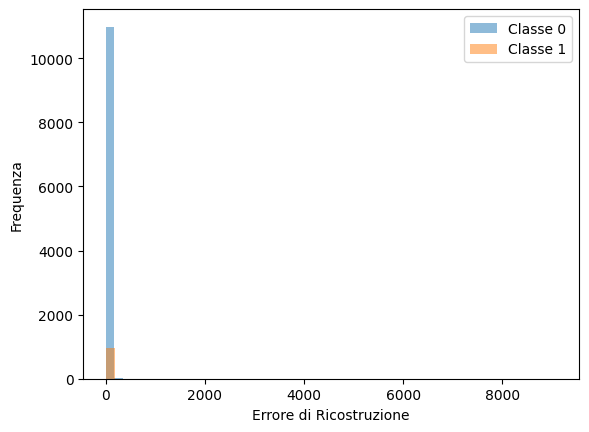

In [10]:
# Distribuzione degli errori di ricostruzione
plt.hist(reconstruction_error[y_test == 0], bins=50, alpha=0.5, label='Classe 0')
plt.hist(reconstruction_error[y_test == 1], bins=50, alpha=0.5, label='Classe 1')
plt.legend()
plt.xlabel('Errore di Ricostruzione')
plt.ylabel('Frequenza')
plt.show()

In [11]:
# 5. Valutazione delle performance
auc = roc_auc_score(y_test, reconstruction_error)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"AUC-ROC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

AUC-ROC: 0.6024
Precision: 0.1083
Recall: 0.0674
F1-Score: 0.0831
Confusion Matrix:
[[10491   535]
 [  899    65]]


In [5]:
# ALTERNATIVA ALL'AUTOENCODER: XGBOOST (prima di questo basta runnare cella import all'inizio del notebook)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# 1. Caricamento del dataset
data = pd.read_csv("../Data/train_data_smote_50_age.csv")
target = data['bacteremia']

# SE VOGLIO SELEZIONARE MANUALMENTE LE FEATURE
# selected_columns = ['neur', 'lymr', 'monor', 'crea', 'age', 'bun', 'crp', 'wbc', 'neu', 'alb', 'mono', 'che', 'lym', 'tp', 'ggt', 'hgb', 'plt', 'glu', 'mg', 'potass', 'ap', 'gbil', 'phos']  # METTERE QUI I NOMI DELLE COLONNE DA INCLUDERE
# selected_columns = ['neur', 'lymr', 'monor', 'crea', 'age', 'bun', 'crp', 'wbc', 'alb', 'che', 'tp', 'hgb']
selected_columns = ['rdw','potass','ca','phos','mg','crea','bun','hs','tp','alb','ap','ggt','ck','crp','age','gbil'] # from DSAE
features = data[selected_columns]

# # SE VOGLIO INCLUDERE TUTTE LE FEATURE
# features = data.drop(columns = ['bacteremia'])

# Normalizzo le feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)  
target = target.to_numpy()

# Split train-test
X_train_bal, X_val, y_train_bal, y_val = train_test_split(X_scaled, target, test_size=0.2, random_state=42)

# Modello XGBoost
model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train_bal, y_train_bal)

# Valutazione
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2232
           1       0.72      0.60      0.65      1076

    accuracy                           0.79      3308
   macro avg       0.77      0.74      0.75      3308
weighted avg       0.79      0.79      0.79      3308

Confusion Matrix:
[[1977  255]
 [ 430  646]]


Confusion Matrix (threshold=0.4):
[[1702  556]
 [ 108 2045]]
              precision    recall  f1-score   support

           0       0.94      0.75      0.84      2258
           1       0.79      0.95      0.86      2153

    accuracy                           0.85      4411
   macro avg       0.86      0.85      0.85      4411
weighted avg       0.87      0.85      0.85      4411

AUC-ROC: 0.9469
Miglior threshold per F1-score: 0.5109


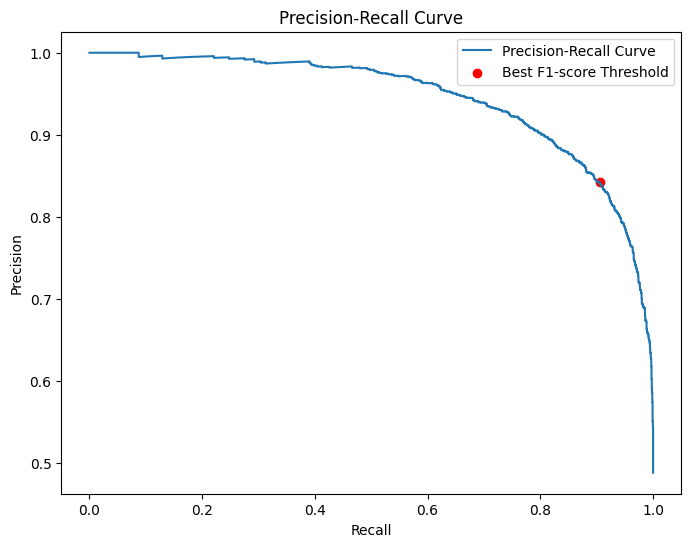

In [ ]:
# PROVA A MIGLIORARE XGBOOST

# Import librerie
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Caricamento dataset
data = pd.read_csv("../Data/train_data.csv")
target = data['bacteremia']

# Selezione feature
selected_columns = ['rdw','potass','ca','phos','mg','crea','bun','hs','tp','alb','ap','ggt','ck','crp','age','gbil']
features = data[selected_columns]

# Normalizzazione feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)  
y = target.to_numpy()

# Split train-test
X_train_bal, X_val, y_train_bal, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Calcolo scale_pos_weight (numero di classe 0 / numero di classe 1)
n_neg = np.sum(y_train_bal == 0)
n_pos = np.sum(y_train_bal == 1)
scale_pos_weight = n_neg / n_pos

# Modello XGBoost migliorato
model = XGBClassifier(
    n_estimators=300,       # Aumento alberi per migliorare il learning
    learning_rate=0.03,     # Ridotto per evitare overfitting
    max_depth=6,            # Aumentato per più capacità predittiva
    scale_pos_weight=scale_pos_weight,  # Bilancia il dataset
    subsample=0.8,          # Evita overfitting
    colsample_bytree=0.8,   # Usa solo l'80% delle feature per ogni albero
    random_state=42
)
model.fit(X_train_bal, y_train_bal)

# Predizioni probabilistiche per ottimizzare threshold
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Definizione threshold (default 0.5 → abbassato a 0.4 per migliorare il recall)
best_threshold = 0.4
y_pred_adjusted = (y_pred_proba > best_threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_adjusted)
print("Confusion Matrix (threshold=0.4):")
print(cm)

# Report di classificazione
print(classification_report(y_val, y_pred_adjusted))

# Calcolo AUC-ROC
auc = roc_auc_score(y_val, y_pred_proba)
print(f"AUC-ROC: {auc:.4f}")

# Curve Precision-Recall per ottimizzare il threshold
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_f1_threshold = thresholds[np.argmax(f1_scores)]
print(f"Miglior threshold per F1-score: {best_f1_threshold:.4f}")

# Plot della curva Precision-Recall
plt.figure(figsize=(8,6))
plt.plot(recalls[:-1], precisions[:-1], label="Precision-Recall Curve")
plt.scatter(recalls[np.argmax(f1_scores)], precisions[np.argmax(f1_scores)], color='red', marker='o', label="Best F1-score Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


c:\Users\bre3\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\bre3\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\bre3\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\bre3\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "

Confusion Matrix (threshold=0.4):
[[1380  822]
 [  63  133]]
              precision    recall  f1-score   support

           0       0.96      0.63      0.76      2202
           1       0.14      0.68      0.23       196

    accuracy                           0.63      2398
   macro avg       0.55      0.65      0.49      2398
weighted avg       0.89      0.63      0.71      2398

AUC-ROC: 0.7133
Miglior threshold per F1-score: 0.8485


C:\Users\bre3\AppData\Local\Temp\ipykernel_12092\2912723535.py:71: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


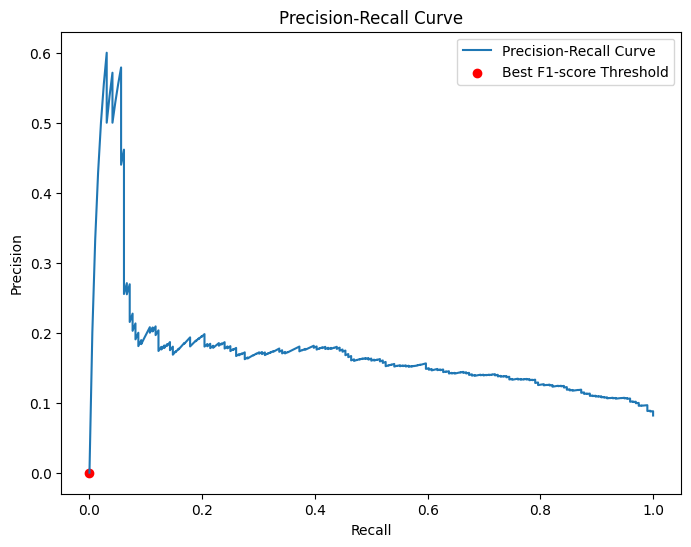

In [1]:
# CON SMOTE APPLICATO IN MODO CORRETTO SOLO SUL TRAIN

# Import librerie
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Caricamento dataset (Dati originali, NON bilanciati)
data = pd.read_csv("../Data/train_data.csv")
target = data['bacteremia']

# Selezione feature
selected_columns = ['rdw', 'potass', 'ca', 'phos', 'mg', 'crea', 'bun', 'hs', 'tp', 'alb', 'ap', 'ggt', 'ck', 'crp', 'age', 'gbil']
features = data[selected_columns]

# Normalizzazione feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)  
y = target.to_numpy()

# Split train-test PRIMA di applicare SMOTE (il test rimane non bilanciato)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Applico SMOTE solo al train set con 50% di bilanciamento
smote = SMOTE(sampling_strategy=0.8, random_state=42)  # Aumenta la classe minoritaria al 50% della maggioritaria
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Ricalcolo scale_pos_weight DOPO SMOTE
n_neg = np.sum(y_train_bal == 0)
n_pos = np.sum(y_train_bal == 1)
scale_pos_weight = n_neg / n_pos

# Modello XGBoost migliorato
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,  # Bilancia il dataset
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_bal, y_train_bal)

# Predizioni probabilistiche per ottimizzare threshold
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Definizione threshold ottimizzato per migliorare recall
best_threshold = 0.3
y_pred_adjusted = (y_pred_proba > best_threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_adjusted)
print("Confusion Matrix (threshold=0.4):")
print(cm)

# Report di classificazione
print(classification_report(y_val, y_pred_adjusted))

# Calcolo AUC-ROC
auc = roc_auc_score(y_val, y_pred_proba)
print(f"AUC-ROC: {auc:.4f}")

# Curve Precision-Recall per ottimizzare il threshold
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_f1_threshold = thresholds[np.argmax(f1_scores)]
print(f"Miglior threshold per F1-score: {best_f1_threshold:.4f}")

# Plot della curva Precision-Recall
plt.figure(figsize=(8,6))
plt.plot(recalls[:-1], precisions[:-1], label="Precision-Recall Curve")
plt.scatter(recalls[np.argmax(f1_scores)], precisions[np.argmax(f1_scores)], color='red', marker='o', label="Best F1-score Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [2]:
scale_pos_weight

np.float64(1.250035415781272)

Confusion Matrix (threshold=0.4):
[[1446  756]
 [  60  136]]
              precision    recall  f1-score   support

           0       0.96      0.66      0.78      2202
           1       0.15      0.69      0.25       196

    accuracy                           0.66      2398
   macro avg       0.56      0.68      0.51      2398
weighted avg       0.89      0.66      0.74      2398

AUC-ROC: 0.7246
Miglior threshold per F1-score: 0.7510


C:\Users\bre3\AppData\Local\Temp\ipykernel_16644\2879454317.py:67: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


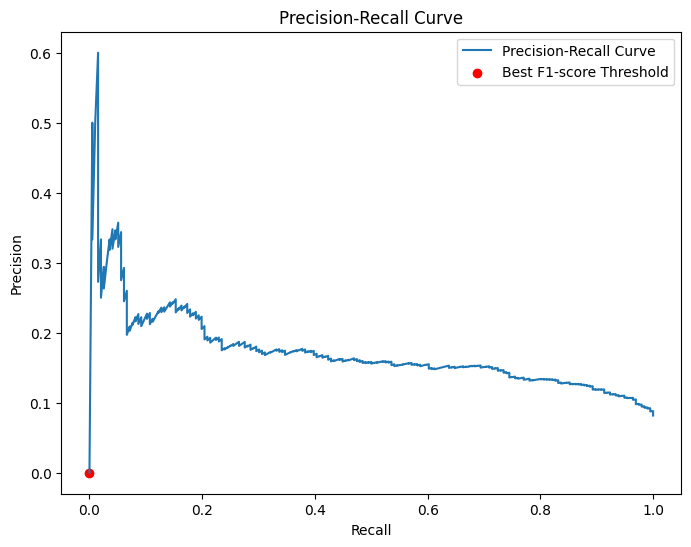

In [2]:
# RANDOM FOREST

# Import librerie
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Caricamento dataset originale
data = pd.read_csv("../Data/train_data.csv")
target = data['bacteremia']

# Selezione feature
# selected_columns = ['rdw','potass','ca','phos','mg','crea','bun','hs','tp','alb','ap','ggt','ck','crp','age','gbil'] #
selected_columns = ['rdw','potass','phos','crea','bun','hs','tp','alb','ap','ggt','ck','glu','age','gbil'] # delta 0.7
# selected_columns = ['potass','phos','crea','bun','hs','tp','ap','ggt','ck','glu'] # delta 0.8
# selected_columns = ['phos','bun','ap','ggt','glu'] # delta 0.9
features = data[selected_columns]

# Normalizzazione feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)  
y = target.to_numpy()

# Split train-test
X_train_bal, X_val, y_train_bal, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # **Applichiamo SMOTE solo ai dati di training**
# smote = SMOTE(sampling_strategy=0.5, random_state=42)
# X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Modello Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,  # Più alberi per stabilità
    max_depth=8,       # Evita overfitting
    min_samples_split=10, # Evita alberi troppo complessi
    class_weight="balanced",  # Per gestire squilibrio tra classi
    random_state=42
)
rf_model.fit(X_train_bal, y_train_bal)

# Predizioni probabilistiche per ottimizzare threshold
y_pred_proba = rf_model.predict_proba(X_val)[:, 1]

# Definizione threshold (default 0.5 → ottimizzato per recall)
best_threshold = 0.4
y_pred_adjusted = (y_pred_proba > best_threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_adjusted)
print("Confusion Matrix (threshold=0.4):")
print(cm)

# Report di classificazione
print(classification_report(y_val, y_pred_adjusted))

# Calcolo AUC-ROC
auc = roc_auc_score(y_val, y_pred_proba)
print(f"AUC-ROC: {auc:.4f}")

# Curve Precision-Recall per ottimizzare il threshold
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_f1_threshold = thresholds[np.argmax(f1_scores)]
print(f"Miglior threshold per F1-score: {best_f1_threshold:.4f}")

# Plot della curva Precision-Recall
plt.figure(figsize=(8,6))
plt.plot(recalls[:-1], precisions[:-1], label="Precision-Recall Curve")
plt.scatter(recalls[np.argmax(f1_scores)], precisions[np.argmax(f1_scores)], color='red', marker='o', label="Best F1-score Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
